In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools

In [3]:
load_file_path=os.path.join('/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline fashion', 'Copy of Baseline fashion 5*5.csv')
print(load_file_path)

save_folder='/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline fashion/processed data'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline fashion/Copy of Baseline fashion 5*5.csv


In [4]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [5]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    #df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
    #df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df

# Example usage:
flops_dict = {"branch1.0FLOPS": 0.314, "branch2.0FLOPS": 0.314, "branch3.0FLOPS": 0.314, "totalFLOPS": 10.577}
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [6]:
def normalize_feature_attribution_final(df):
    """
    Final modification of the normalization of feature attributions for each layer.

    Parameters:
    df (DataFrame): The dataframe containing the feature attributions.

    Returns:
    DataFrame: A modified dataframe with normalized feature attributions for each layer.
    """
    # Columns to be normalized
    layers = ['branch1.0','branch2.0','branch3.0']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    df.drop(['sum_feature_attr','branch1.0','branch2.0','branch3.0'], axis=1, inplace=True)

    return df

# Example usage of the final modified function
normalized_final_df = normalize_feature_attribution_final(df.copy())

get average and normalzied variance for each combination of hyperparameter

In [7]:
def calculate_normalized_variance(df, method, flops_dict):
    """
    Modified combined function to calculate the average and normalized variance of each layer's feature attribution
    for a given method, including both average and variance in one dataframe, along with average accuracy after each epoch.
    This version also includes FLOPS information.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    method (str): The method to filter the data ('deeplift' or 'integrated_gradients').
    flops_dict (dict): Dictionary containing FLOPS values for different layers.

    Returns:
    DataFrame: A dataframe with the average and normalized variance for each layer combined, and average accuracy after each epoch, including FLOPS info.
    """
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_branch1.0','norm_branch2.0','norm_branch3.0']
    accuracy_columns = ['train accuracy epoch0', 'test accuracy epoch0']

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var_norm = grouped[layers].var()
    avg_acc = grouped[accuracy_columns].mean()

    # Calculate normalized variance (variance/mean)
    norm_var = var_norm / avg_norm

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'norm_var_{layer}'] = norm_var[layer]

    # Calculate the average normalized variance across the selected layers
    norm_var_layers = [f'norm_var_{layer}' for layer in layers]
    combined_df['avg_normalized_variance'] = combined_df[norm_var_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
combined_avg_norm_var_acc_deeplift = calculate_normalized_variance(normalized_final_df, 'deeplift', flops_dict)

In [8]:
combined_avg_norm_var_acc_deeplift.to_csv(save_folder+"/Baseline fashion 5*5 dl.csv")
combined_avg_norm_var_acc_deeplift=pd.read_csv(save_folder+"/Baseline fashion 5*5 dl.csv")

In [9]:
def filter_by_accuracy(df, threshold=70.0):
    """
    Function to filter out rows where the average accuracy across epoch 3 (both train and test) is lower than a specified threshold.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    threshold (float): The threshold for average accuracy in epoch 3.

    Returns:
    DataFrame: A filtered dataframe with rows having average epoch 3 accuracy higher than the threshold.
    """
    # Columns representing epoch 3 accuracy
    epoch_2_accuracy_cols = ['test accuracy epoch0']

    # Calculate the average accuracy for epoch 3
    df['final_test_accuracy'] = df[epoch_2_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return filtered_df

# Apply the function to the dataframes for 'deeplift' and 'integrated_gradients'
filtered_deeplift = filter_by_accuracy(combined_avg_norm_var_acc_deeplift)

# Display the first few rows of the filtered dataframes
filtered_deeplift

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_branch1.0,norm_branch2.0,norm_branch3.0,norm_var_norm_branch1.0,norm_var_norm_branch2.0,norm_var_norm_branch3.0,avg_normalized_variance,train accuracy epoch0,test accuracy epoch0,branch1.0FLOPS,branch2.0FLOPS,branch3.0FLOPS,totalFLOPS,final_test_accuracy
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.318447,0.345022,0.336531,0.008944,0.015012,0.006149,0.010035,86.005333,88.078000,0.314,0.314,0.314,10.577,88.078000
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.319045,0.342287,0.338667,0.006118,0.010447,0.004207,0.006924,85.739667,87.747333,0.314,0.314,0.314,10.577,87.747333
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.322537,0.336184,0.341279,0.004021,0.008204,0.003757,0.005327,85.109333,87.099333,0.314,0.314,0.314,10.577,87.099333
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.322111,0.341794,0.336095,0.010342,0.017787,0.006183,0.011438,85.995889,88.234000,0.314,0.314,0.314,10.577,88.234000
4,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.322165,0.339806,0.338029,0.006587,0.012188,0.005041,0.007939,85.703000,87.999333,0.314,0.314,0.314,10.577,87.999333
5,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.322505,0.338317,0.339178,0.004559,0.008544,0.003983,0.005695,85.237556,87.620667,0.314,0.314,0.314,10.577,87.620667
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.327518,0.348714,0.323768,0.015286,0.023999,0.008458,0.015914,86.276778,88.410000,0.314,0.314,0.314,10.577,88.410000
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.321850,0.344842,0.333308,0.011264,0.016215,0.005782,0.011087,86.056667,88.334000,0.314,0.314,0.314,10.577,88.334000
8,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.320342,0.342365,0.337293,0.007025,0.012370,0.004549,0.007981,85.458556,87.184000,0.314,0.314,0.314,10.577,87.184000
9,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.329058,0.345467,0.325475,0.018749,0.028431,0.010552,0.019244,86.256111,88.589333,0.314,0.314,0.314,10.577,88.589333


# Graph

In [10]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    """
    Plots bar graphs of the average variance of each layer and the overall average variance
    for multiple values of a given hyperparameter.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    hyperparam (str): The hyperparameter to vary.
    variables (list): A list of values for the hyperparameter to compare.

    Returns:
    None: The function plots graphs directly.
    """
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'norm_var' in col]
    variance_columns.append('avg_normalized_variance')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


In [11]:
filtered_deeplift.to_csv(save_folder+"/Baseline fashion 5*5 dl ave var.csv")

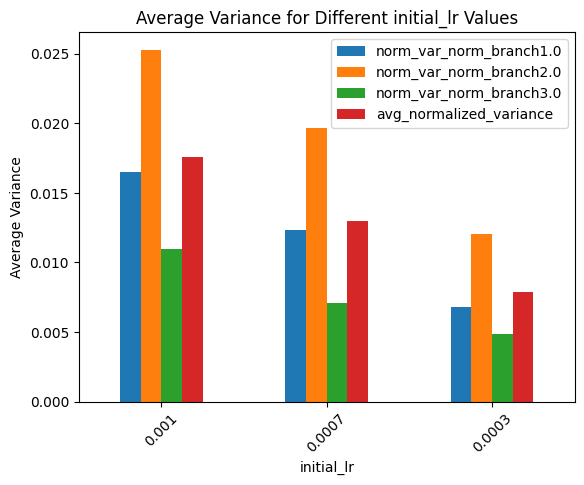

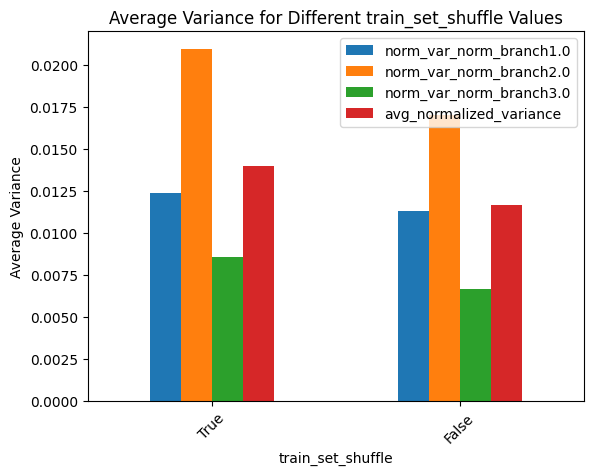

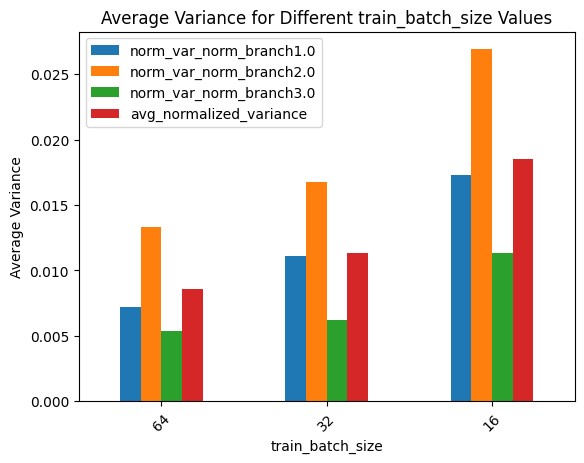

In [12]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_set_shuffle': [True,False],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(filtered_deeplift, hyperparam, variables)

# T test

In [13]:
def perform_t_test(df, target_column, condition_column, choice1, choice2):
    # Splitting the data into two groups based on the condition
    group1 = df[df[condition_column] == choice1][target_column]
    group2 = df[df[condition_column] == choice2][target_column]

    # Performing the independent t-test
    t_statistic, p_value = ttest_ind(group1, group2)

    return t_statistic, p_value

initial_lr

In [14]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 1.2653315467500998 P-value: 0.23444029714405806


In [15]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 2.884934876009328 P-value: 0.016247558333163412


In [16]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 2.6339401456020686 P-value: 0.024992568153579364


train_set_shuffle

In [17]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_set_shuffle', True, False)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.7492052382506172 P-value: 0.46460679772371083


train_batch_size

In [18]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 64, 32)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -1.506044518637387 P-value: 0.16297290169813505


In [19]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 64, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -3.0018850601864076 P-value: 0.013300743864555742


In [20]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 32, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -2.105527377035646 P-value: 0.06150306894231394


# Paired T test

In [21]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [22]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [23]:
def generate_hyperparameter_combinations(hyperparams):
    """
    Generate a sequence of hyperparameter combinations.

    :param hyperparams: A dictionary where keys are the names of hyperparameters,
                        and values are lists of possible choices for each hyperparameter.
    :return: A list of dictionaries, each representing a unique combination of hyperparameters.
    """
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [24]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

initial_lr

In [25]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0124252874205502 0.0103594607193066
0.0161897296538087 0.0134439333562996
0.0290604720928854 0.0192439598884033
0.0098421940114414 0.0079812866139725
0.0124765749654371 0.0110870936036993
0.0254881852469003 0.015914238793831
T-statistic: 2.8085575314410525 One-sided P-value: 0.018806059872292197


In [26]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0103594607193066 0.0056951311764323
0.0134439333562996 0.0079387782521702
0.0192439598884033 0.0114375378069511
0.0079812866139725 0.0053273374474304
0.0110870936036993 0.0069241294687747
0.015914238793831 0.0100351609220653
T-statistic: 7.194511564225091 One-sided P-value: 0.0004039476870689082


In [27]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0124252874205502 0.0056951311764323
0.0161897296538087 0.0079387782521702
0.0290604720928854 0.0114375378069511
0.0098421940114414 0.0053273374474304
0.0124765749654371 0.0069241294687747
0.0254881852469003 0.0100351609220653
T-statistic: 4.319727067074949 One-sided P-value: 0.003786280675927522


train_set_shuffle

In [28]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_set_shuffle', True, False)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0124252874205502 0.0098421940114414
0.0161897296538087 0.0124765749654371
0.0290604720928854 0.0254881852469003
0.0103594607193066 0.0079812866139725
0.0134439333562996 0.0110870936036993
0.0192439598884033 0.015914238793831
0.0056951311764323 0.0053273374474304
0.0079387782521702 0.0069241294687747
0.0114375378069511 0.0100351609220653
T-statistic: 5.9010892764403975 One-sided P-value: 0.00018065082711395542


train_batch_size

In [29]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 32, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0161897296538087 0.0124252874205502
0.0124765749654371 0.0098421940114414
0.0134439333562996 0.0103594607193066
0.0110870936036993 0.0079812866139725
0.0079387782521702 0.0056951311764323
0.0069241294687747 0.0053273374474304
T-statistic: 8.858649156220965 One-sided P-value: 0.00015236944464665962


In [30]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 32)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0290604720928854 0.0161897296538087
0.0254881852469003 0.0124765749654371
0.0192439598884033 0.0134439333562996
0.015914238793831 0.0110870936036993
0.0114375378069511 0.0079387782521702
0.0100351609220653 0.0069241294687747
T-statistic: 3.8609069663184115 One-sided P-value: 0.0059345399478113155


In [31]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0290604720928854 0.0124252874205502
0.0254881852469003 0.0098421940114414
0.0192439598884033 0.0103594607193066
0.015914238793831 0.0079812866139725
0.0114375378069511 0.0056951311764323
0.0100351609220653 0.0053273374474304
T-statistic: 4.813857829404469 One-sided P-value: 0.0024122107353099485


#layer feature attribution rank frequency comparison

In [32]:
normalized_df = normalized_final_df[normalized_final_df['method'] == 'deeplift']
normalized_df_highacc = filter_by_accuracy(normalized_df)
normalized_df_highacc

<ipython-input-9-78e4492ffc89>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_test_accuracy'] = df[epoch_2_accuracy_cols].mean(axis=1)


,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,train accuracy epoch0,test accuracy epoch0,method,run,branch1.0FLOPS,branch2.0FLOPS,branch3.0FLOPS,totalFLOPS,norm_branch1.0,norm_branch2.0,norm_branch3.0,final_test_accuracy
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,85.691667,87.71,deeplift,0,0.314,0.314,0.314,10.577,0.262230,0.324573,0.413197,87.71
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,85.928333,88.23,deeplift,1,0.314,0.314,0.314,10.577,0.333497,0.358564,0.307940,88.23
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,85.356667,87.22,deeplift,2,0.314,0.314,0.314,10.577,0.288604,0.383436,0.327961,87.22
6,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,85.751667,88.35,deeplift,3,0.314,0.314,0.314,10.577,0.419138,0.145148,0.435713,88.35
8,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,85.625000,88.37,deeplift,4,0.314,0.314,0.314,10.577,0.288694,0.356114,0.355191,88.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,86.226667,87.96,deeplift,10,0.314,0.314,0.314,10.577,0.273695,0.431668,0.294637,87.96
532,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,85.793333,87.89,deeplift,11,0.314,0.314,0.314,10.577,0.301235,0.333837,0.364928,87.89
534,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,86.080000,87.98,deeplift,12,0.314,0.314,0.314,10.577,0.351282,0.283742,0.364977,87.98
536,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,85.871667,87.83,deeplift,13,0.314,0.314,0.314,10.577,0.334145,0.303231,0.362625,87.83


In [33]:
# Select the columns of interest
cols_of_interest = ['norm_branch1.0', 'norm_branch2.0', 'norm_branch3.0']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-33-85bc6b39743e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


132    78
231    67
123    47
312    47
213    30
321     1
Name: rank_combination, dtype: int64